In [ ]:
!pip install ortools
import numpy as np
import pandas as pd
from math import ceil
from ortools.linear_solver import pywraplp
import itertools

# Define Constants

In [ ]:
TIMEZONES = {
  'DAL': -1,
  'HOU': -1,
  'LAS': -3,
  'DEN': -2,
  'OAK': -3,
  'PHX': -2,
  'BWI': 0,
  'MDW': -1,
  'MCO': 0,
  'LAX': -3,
  'FLL': 0,
  'AUS': -1,
  'LGA': 0,
  'SEA': -3,
  'BOS': 0
}

MIN_LAYOVER_TIME = 60
MAX_LAYOVER_TIME = 420
PLANE_CAPACITY = 180
MIN_PASSENGERS_TO_OPERATE = 60
NUM_FLIGHTS = {'default': 10, 'BWI': 15, 'MDW': 15, 'DAL': 12, 'DEN': 12, 'LAS': 15}
EST_EARLIEST_TIME = 7
EST_LATEST_TIME = 21
AIRPORTS = ['BOS', 'BWI', 'DAL']

## Flight Durations

In [ ]:
xls = 'Airline Network.xlsx'
# Load the "Flight Times" sheet
flight_times_df = pd.read_excel(xls, sheet_name='Flight Times', header=1, index_col='Unnamed: 1').iloc[:15].drop('Unnamed: 0', axis=1)
flight_times_df = flight_times_df.loc[AIRPORTS, AIRPORTS]
flight_times_df = flight_times_df[flight_times_df.columns].replace('X', '0')
flight_times_df = flight_times_df[flight_times_df.columns].astype(int)
flight_times_df

,BOS,BWI,DAL
BOS,0,100,0
BWI,90,0,215
DAL,0,165,0


# Demand Data

In [ ]:

airport_codes = list(flight_times_df.index)
# Create a dataframe to represent demand between each pair of airports
demand_data_df = pd.DataFrame(index=airport_codes, columns=airport_codes)

# Populate the dataframe with random demand values
# For simplicity, let's assume demand values can range from 50 to 300 passengers for each route
np.random.seed(42) # For reproducibility
for origin in airport_codes:
    for destination in airport_codes:
        if origin != destination:
            demand_data_df.loc[origin, destination] = np.random.randint(100, 300)
        else:
            demand_data_df.loc[origin, destination] = 0 # No demand for flights from an airport to itself

demand_data_df

,BOS,BWI,DAL
BOS,0,202,279
BWI,192,0,114
DAL,206,171,0


# Operating Costs

In [ ]:
operating_costs_df = pd.read_excel(xls, sheet_name='Operating Cost', header=1, index_col='Unnamed: 1').iloc[:15].drop('Unnamed: 0', axis=1)
operating_costs_df = operating_costs_df.loc[AIRPORTS, AIRPORTS]

operating_costs_df = operating_costs_df[operating_costs_df.columns].replace('X', '0')
operating_costs_df = operating_costs_df[operating_costs_df.columns].astype(int)
operating_costs_df

,BOS,BWI,DAL
BOS,0,8291,0
BWI,8855,0,18415
DAL,0,18083,0


# Utility Functions

In [ ]:
def get_possible_direct_flight_times(flight_times_df):
  airport_codes = list(flight_times_df.index)
  direct_flight_options = {}
  for i in airport_codes:
    timezone = TIMEZONES[i]
    for j in airport_codes:
      duration = flight_times_df.loc[i,j]
      if i != j and duration != 0:
          for t in list(range(EST_EARLIEST_TIME-timezone, EST_LATEST_TIME+1)):
              direct_flight_options[(i, j, t-timezone)] = (t-timezone, t-timezone + (duration/60))
  return direct_flight_options

def get_flight_times(flight_times_df):
  flight_times = {}

  for origin in flight_times_df.index:
      for destination in flight_times_df.columns:
          # Assuming 0 or negative values indicate no demand or invalid routes
          if flight_times_df.loc[origin, destination] > 0:
              flight_times[(origin, destination)] = flight_times_df.loc[origin, destination]
  return flight_times

def get_operating_costs(operating_costs_df):
  operating_costs = {}

  # Iterate over each cell in the DataFrame to populate the demand_data dictionary
  for origin in operating_costs_df.index:
      for destination in operating_costs_df.columns:
          # Assuming 0 or negative values indicate no demand or invalid routes
          if operating_costs_df.loc[origin, destination] > 0:
            for hour in range(EST_EARLIEST_TIME, EST_LATEST_TIME+4):
              operating_costs[(origin, destination, hour-TIMEZONES[origin])] = operating_costs_df.loc[origin, destination]
  return operating_costs

def get_demand_data(demand_data_df):
  demand_data = {}
  # Iterate over each cell in the DataFrame to populate the demand_data dictionary
  for origin in demand_data_df.index:
      for destination in demand_data_df.columns:
          # Assuming 0 or negative values indicate no demand or invalid routes
          if demand_data_df.loc[origin, destination] > 0:
              demand_data[(origin, destination)] = demand_data_df.loc[origin, destination]

  return demand_data

# def is_feasible_connection(i, j, k, t1, t2):
#   if t1-TIMEZONES[i] < EST_EARLIEST_TIME or t2-TIMEZONES[j] < EST_EARLIEST_TIME:
#     return False
#   if t1-TIMEZONES[i] > EST_LATEST_TIME or t2-TIMEZONES[j] > EST_LATEST_TIME:
#     return False
#   flight_times_dict = flight_times_df.to_dict()
#   if flight_times_dict[i][j] > 0 and flight_times_dict[j][k] > 0:
#     if t2 > t1:
#       if t1 + (flight_times_dict[i][j]/60) + (MIN_LAYOVER_TIME/60) <= t2:
#         if MAX_LAYOVER_TIME is not None:
#           if t1 + (flight_times_dict[i][j]/60) + (MAX_LAYOVER_TIME/60) > t2:
#             return False
#         return True
#   return False
def is_feasible_connection(i, j, k, t1, t2):
    # Check if the departure time at the first airport is before the earliest allowed time
    if t1 + TIMEZONES[i] < EST_EARLIEST_TIME:
        return False
    # Check if the departure time at the second airport is before the earliest allowed time
    if t2 + TIMEZONES[j] < EST_EARLIEST_TIME:
        return False
    # Check if the departure time at the first airport is after the latest allowed time
    if t1 + TIMEZONES[i] > EST_LATEST_TIME:
        return False
    # Check if the departure time at the second airport is after the latest allowed time
    if t2 + TIMEZONES[j] > EST_LATEST_TIME:
        return False

    # Get the flight times dictionary from the dataframe
    flight_times_dict = flight_times_df.to_dict()
    # Check if there's a direct flight from i to j and from j to k
    if flight_times_dict[i][j] > 0 and flight_times_dict[j][k] > 0:
        # Ensure that the connecting flight's departure is after the arrival of the first flight
        arrival_time_first_leg = t1 + flight_times_dict[i][j] / 60
        if t2 >= arrival_time_first_leg + (MIN_LAYOVER_TIME / 60):
            # If there's a maximum layover time, check that it is not exceeded
            if MAX_LAYOVER_TIME is not None:
                if arrival_time_first_leg + (MAX_LAYOVER_TIME / 60) > t2:
                    return False
                # If there's no maximum layover time or it's not exceeded, the connection is feasible
            return True

    # If none of the above conditions are met, the connection is not feasible
    return False

def format_time(t):
  if t >= 10:
    t_str = f"{str(t)}:00 EST"
  else:
    t_str = f"0{str(t)}:00 EST"
  return t_str


In [ ]:
%%time
demand_data = get_demand_data(demand_data_df)
flight_schedule = get_possible_direct_flight_times(flight_times_df)
operating_costs = get_operating_costs(operating_costs_df)

# Initialize the solver
solver = pywraplp.Solver.CreateSolver('SCIP')

# Decision Variables
X = {}  # Passengers on a direct flight
Y = {}  # Binary variable for whether a direct flight is operated
X_conn = {}  # Passengers on a connection flight
Y_conn = {}  # Binary variable for whether a connection flight is operated

# Create decision variables for passengers on direct flights
for flight in flight_schedule:
  i, j, t = flight
  X[(i, j, t)] = solver.IntVar(0, PLANE_CAPACITY, f'X_{i}_{j}_{t}')
  Y[(i, j, t)] = solver.BoolVar(f'Y_{i}_{j}_{t}')

# Create the decision variables for connecting flights
for i in airport_codes:
  for j in airport_codes:
    if i != j:
      for k in airport_codes:
        if k != i and k != j:  # Final destination is different from origin and connection
          for t1 in range(EST_EARLIEST_TIME, EST_LATEST_TIME+4):
            if flight_schedule.get((i, j, t1)) is not None:
              for t2 in range(EST_EARLIEST_TIME, EST_LATEST_TIME+4):
                # Check if connection is feasible (e.g., based on layover constraints)
                if is_feasible_connection(i, j, k, t1, t2):
                  # Define the variable for this specific connection
                  X_conn[(i, j, k, t1, t2)] = solver.IntVar(0, 180, f'X_conn_{i}_{j}_{k}_{t1}_{t2}')
                  Y_conn[(i, j, k, t1, t2)] = solver.BoolVar(f'Y_conn_{i}_{j}_{k}_{t1}_{t2}')

# Constraints
for (i, k), demand in demand_data.items():
    # Add Constraint for number of flights allowed to go from city i directly in one day
    solver.Add(solver.Sum([Y[(i, k, t)] for t in range(EST_EARLIEST_TIME, EST_LATEST_TIME+4) if (i, k, t) in Y]) <= NUM_FLIGHTS.get(i, NUM_FLIGHTS['default']))
    # Sum passengers on direct flights from i to k
    direct_flights_passengers = solver.Sum([X[(i, k, t)] for t in range(EST_EARLIEST_TIME, EST_LATEST_TIME+4) if (i, k, t) in X])
    # Sum passengers on connecting flights for each possible connecting city j
    connecting_flights_passengers = solver.Sum([X_conn[(i, j, k, t1, t2)] for j in airport_codes if j != i and j != k for t1 in range(EST_EARLIEST_TIME, EST_LATEST_TIME+4) for t2 in range(EST_EARLIEST_TIME, EST_LATEST_TIME+4) if (i, j, k, t1, t2) in X_conn])
    # Add Constraint to meet demand for travelers from each origin airport
    solver.Add(direct_flights_passengers + connecting_flights_passengers >= demand)

for i, j, t in flight_schedule:
  # Get the number of passengers flying direct from i to j at departure time t
  direct_passengers = X[(i, j, t)]

  # Get the number of passengers using this flight as their first leg of the trip
  connecting_passengers_first_leg = solver.Sum(
      [X_conn[(i, j, k, t, t2)]
      for k in airport_codes if k != i and k != j
      for t2 in range(EST_EARLIEST_TIME, EST_LATEST_TIME+4)
      if (i, j, k, t, t2) in X_conn]
  )

  # Get the number of passengers using this flight as their second leg of the trip
  connecting_passengers_second_leg = solver.Sum(
    [X_conn[(l, i, j, t1, t)]
    for l in airport_codes
    if l != j and l != i
    for t1 in range(EST_EARLIEST_TIME, EST_LATEST_TIME+4)
    if (l, i, j, t1, t) in X_conn]
  )

  # Add a constraint to ensure that the number of total passengers on a flight from i to j at time t are less than or equal to the planes max capacity
  solver.Add(solver.Sum([direct_passengers, connecting_passengers_first_leg, connecting_passengers_second_leg]) <= PLANE_CAPACITY * Y[i, j, t])
  # Add a constraint to ensure that the number of total passengers on a flight from i to j at time t meets the requirement for minimum # of passengers to operate
  solver.Add(solver.Sum([direct_passengers, connecting_passengers_first_leg, connecting_passengers_second_leg]) >= MIN_PASSENGERS_TO_OPERATE * Y[i, j, t])

# Objective Function: Minimize total operating cost
solver.Minimize(solver.Sum([operating_costs.get((i, j, t), 0) * Y[(i, j, t)] for (i, j, t) in flight_schedule]))

print(f"Decision Variables: {solver.NumVariables()}")
print(f"Constraints: {solver.NumConstraints()}")
#Solve the model
status = solver.Solve()

# Output the solution
if status == pywraplp.Solver.OPTIMAL:
  print('Optimal Solution Found:')
  print("="*150)
  print(f"Flight Schedule:")
  print("-"*150)
  for i, j, t in sorted(Y, key=lambda x: x[2]):
      if Y[(i, j, t)].solution_value() > 0:
        direct_passengers = int(X[(i, j, t)].solution_value())
        first_leg_passengers = int(sum([X_conn[(i, j, k, t, t2)].solution_value() for k in airport_codes if k != i and k != j for t2 in range(EST_EARLIEST_TIME, EST_LATEST_TIME+4) if (i, j, k, t, t2) in X_conn]))
        second_leg_passengers = int(sum([X_conn[(l, i, j, t1, t)].solution_value() for l in airport_codes if l != j and l != i for t1 in range(EST_EARLIEST_TIME, EST_LATEST_TIME+4) if (l, i, j, t1, t) in X_conn]))
        total_passengers = int(direct_passengers + first_leg_passengers + second_leg_passengers)
        print(f'Flight {i} to {j} at {format_time(t)} is operated, carrying {total_passengers:>3} passengers ({direct_passengers:>3} direct, {first_leg_passengers:>3} first-leg connectors, {second_leg_passengers:>3} second-leg connectors).')
  print("="*150)
  print(f"Connecting Itineraries:")
  print("-"*150)
  for i, j, k, t1, t2 in sorted(X_conn, key=lambda x: x[3]):
      if X_conn[(i, j, k, t1, t2)].solution_value() > 0:
          print(f'Connecting flights from {i} to {j} at {format_time(t1)} and {j} to {k} at {format_time(t2)} are operated, carrying {int(X_conn[(i, j, k, t1, t2)].solution_value())} connecting passengers.')
  print("="*150)
  print(f"Operating Cost:")
  print("-"*150)
  print(f'${solver.Objective().Value():,.2f}')
  print("="*150)
else:
  print('No optimal solution found.')


Decision Variables: 166
Constraints: 130
Optimal Solution Found:
Flight Schedule:
------------------------------------------------------------------------------------------------------------------------------------------------------
Flight BOS to BWI at 07:00 EST is operated, carrying 121 passengers ( 22 direct,  99 first-leg connectors,   0 second-leg connectors).
Flight BWI to DAL at 07:00 EST is operated, carrying 180 passengers (180 direct,   0 first-leg connectors,   0 second-leg connectors).
Flight BOS to BWI at 08:00 EST is operated, carrying 180 passengers (  0 direct, 180 first-leg connectors,   0 second-leg connectors).
Flight DAL to BWI at 09:00 EST is operated, carrying 180 passengers (  0 direct, 180 first-leg connectors,   0 second-leg connectors).
Flight BWI to BOS at 10:00 EST is operated, carrying 180 passengers (180 direct,   0 first-leg connectors,   0 second-leg connectors).
Flight DAL to BWI at 10:00 EST is operated, carrying 180 passengers (154 direct,  26 first-l

In [ ]:
with open('solution.txt', 'w') as f:
  f.write(solver.ExportModelAsLpFormat(False).replace('\\', '').replace(',_', ','))

In [ ]:
demand_data_df['Total Demand'] = demand_data_df.sum(axis=1)
demand_data_df

,BOS,BWI,DAL,Total Demand
BOS,0,202,279,481
BWI,192,0,114,306
DAL,206,171,0,377


In [ ]:
def get_num_variables(solver):
  return solver.NumVariables()

def get_num_constraints(solver):
  return solver.NumConstraints()

solvers = []

all_flights = ['DAL', 'HOU', 'LAS', 'DEN', 'OAK', 'PHX', 'BWI', 'MDW', 'MCO', 'LAX', 'FLL', 'AUS', 'LGA', 'SEA', 'BOS']
for i in range(3, len(all_flights)+1):
  flights = all_flights[:i]

  # Load the "Flight Times" sheet
  flight_times_df = pd.read_excel(xls, sheet_name='Flight Times', header=1, index_col='Unnamed: 1').iloc[:15].drop('Unnamed: 0', axis=1)
  flight_times_df = flight_times_df.loc[flights, flights]
  flight_times_df = flight_times_df[flight_times_df.columns].replace('X', '0')
  flight_times_df = flight_times_df[flight_times_df.columns].astype(int)
  operating_costs_df = pd.read_excel(xls, sheet_name='Operating Cost', header=1, index_col='Unnamed: 1').iloc[:15].drop('Unnamed: 0', axis=1)
  operating_costs_df = operating_costs_df.loc[flights, flights]
  operating_costs_df = operating_costs_df[operating_costs_df.columns].replace('X', '0')
  operating_costs_df = operating_costs_df[operating_costs_df.columns].astype(int)
  airport_codes = list(flight_times_df.index)
  # Create a dataframe to represent demand between each pair of airports
  demand_data_df = pd.DataFrame(index=flights, columns=flights)

  # Populate the dataframe with random demand values
  # For simplicity, let's assume demand values can range from 50 to 300 passengers for each route
  np.random.seed(42) # For reproducibility
  for origin in flights:
      for destination in flights:
          if origin != destination:
              demand_data_df.loc[origin, destination] = np.random.randint(700, 1000)
          else:
              demand_data_df.loc[origin, destination] = 0

  demand_data = get_demand_data(demand_data_df)
  flight_schedule = get_possible_direct_flight_times(flight_times_df)
  operating_costs = get_operating_costs(operating_costs_df)

  # Initialize the solver
  solver = pywraplp.Solver.CreateSolver('SCIP')

  # Decision Variables
  X = {}  # Passengers on a direct flight
  Y = {}  # Binary variable for whether a direct flight is operated
  X_conn = {}  # Passengers on a connection flight
  Y_conn = {}  # Binary variable for whether a connection flight is operated

  # Create decision variables for passengers on direct flights
  for flight in flight_schedule:
    i, j, t = flight
    X[(i, j, t)] = solver.IntVar(0, PLANE_CAPACITY, f'X_{i}_{j}_{t}')
    Y[(i, j, t)] = solver.BoolVar(f'Y_{i}_{j}_{t}')

  # Create the decision variables for connecting flights
  for i in airport_codes:
    for j in airport_codes:
      if i != j:
        for k in airport_codes:
          if k != i and k != j:  # Final destination is different from origin and connection
            for t1 in range(EST_EARLIEST_TIME, EST_LATEST_TIME+4):
              if flight_schedule.get((i, j, t1)) is not None:
                for t2 in range(EST_EARLIEST_TIME, EST_LATEST_TIME+4):
                  # Check if connection is feasible (e.g., based on layover constraints)
                  if is_feasible_connection(i, j, k, t1, t2):
                    # Define the variable for this specific connection
                    X_conn[(i, j, k, t1, t2)] = solver.IntVar(0, 180, f'X_conn_{i}_{j}_{k}_{t1}_{t2}')
                    Y_conn[(i, j, k, t1, t2)] = solver.BoolVar(f'Y_conn_{i}_{j}_{k}_{t1}_{t2}')

  # Constraints
  for (i, k), demand in demand_data.items():
      # Add Constraint for number of flights allowed to go from city i directly in one day
      solver.Add(solver.Sum([Y[(i, k, t)] for t in range(EST_EARLIEST_TIME, EST_LATEST_TIME+4) if (i, k, t) in Y]) <= NUM_FLIGHTS.get(i, NUM_FLIGHTS['default']))
      # Sum passengers on direct flights from i to k
      direct_flights_passengers = solver.Sum([X[(i, k, t)] for t in range(EST_EARLIEST_TIME, EST_LATEST_TIME+4) if (i, k, t) in X])
      # Sum passengers on connecting flights for each possible connecting city j
      connecting_flights_passengers = solver.Sum([X_conn[(i, j, k, t1, t2)] for j in airport_codes if j != i and j != k for t1 in range(EST_EARLIEST_TIME, EST_LATEST_TIME+4) for t2 in range(EST_EARLIEST_TIME, EST_LATEST_TIME+4) if (i, j, k, t1, t2) in X_conn])
      # Add Constraint to meet demand for travelers from each origin airport
      solver.Add(direct_flights_passengers + connecting_flights_passengers >= demand)

  for i, j, t in flight_schedule:
    # Get the number of passengers flying direct from i to j at departure time t
    direct_passengers = X[(i, j, t)]

    # Get the number of passengers using this flight as their first leg of the trip
    connecting_passengers_first_leg = solver.Sum(
        [X_conn[(i, j, k, t, t2)]
        for k in airport_codes if k != i and k != j
        for t2 in range(EST_EARLIEST_TIME, EST_LATEST_TIME+4)
        if (i, j, k, t, t2) in X_conn]
    )

    # Get the number of passengers using this flight as their second leg of the trip
    connecting_passengers_second_leg = solver.Sum(
      [X_conn[(l, i, j, t1, t)]
      for l in airport_codes
      if l != j and l != i
      for t1 in range(EST_EARLIEST_TIME, EST_LATEST_TIME+4)
      if (l, i, j, t1, t) in X_conn]
    )

    # Add a constraint to ensure that the number of total passengers on a flight from i to j at time t are less than or equal to the planes max capacity
    solver.Add(solver.Sum([direct_passengers, connecting_passengers_first_leg, connecting_passengers_second_leg]) <= PLANE_CAPACITY * Y[i, j, t])
    # Add a constraint to ensure that the number of total passengers on a flight from i to j at time t meets the requirement for minimum # of passengers to operate
    solver.Add(solver.Sum([direct_passengers, connecting_passengers_first_leg, connecting_passengers_second_leg]) >= MIN_PASSENGERS_TO_OPERATE * Y[i, j, t])

  # Objective Function: Minimize total operating cost
  solver.Minimize(solver.Sum([operating_costs.get((i, j, t), 0) * Y[(i, j, t)] for (i, j, t) in flight_schedule]))
  solvers.append(solver)

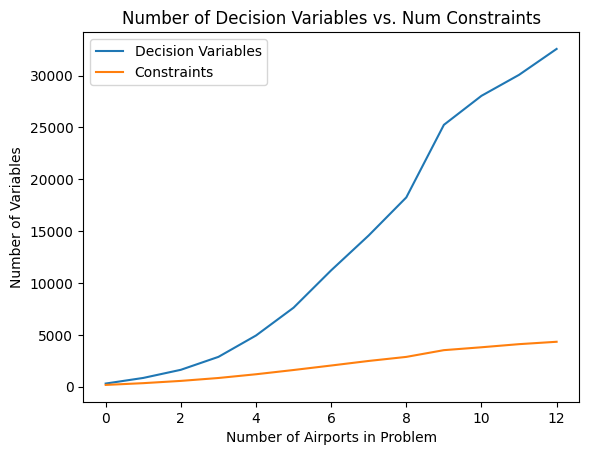

In [ ]:
decision_variables = [solver.NumVariables() for solver in solvers]
constraints = [solver.NumConstraints() for solver in solvers]

import matplotlib.pyplot as plt

plt.plot(decision_variables, label='Decision Variables')
plt.plot(constraints, label='Constraints')
plt.title('Number of Decision Variables vs. Num Constraints')
plt.xlabel('Number of Airports in Problem')
plt.ylabel('Number of Variables')
plt.legend()
plt.show()